# scRNA vs snRNA

Compare expression of comparable sets from scRNA and multiome snRNA.

In [1]:
library(Seurat)
library(ggplot2)
library(scales)
library(Matrix)
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, 

## Load Data

### scRNA

In [2]:
scrna = readRDS("../20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")

In [17]:
atac.to.rna.metadata = read.table("../20200828_RNA_Seurat/sessions/20210725_n59378/atac.20210717_n62599.cluster.transfer.tsv", header=T)
head(atac.to.rna.metadata)

,barcode,sample,atac_cluster
,<fct>,<fct>,<int>
1,AAACCCAAGAGTGACC-1,D0,1
2,AAACCCAAGTGCCAGA-1,D0,1
3,AAACCCACACCATTCC-1,D0,1
4,AAACCCACACGCGTCA-1,D0,1
5,AAACCCAGTCCATAGT-1,D0,1
6,AAACCCAGTTATTCTC-1,D0,1


In [18]:
scrna@meta.data$trans_clst = atac.to.rna.metadata$atac_cluster
scrna = SetIdent(scrna, value="trans_clst")

### snRNA

In [2]:
snrna = readRDS("../20220606_Multiome_RNA_Seurat/sessions/20220608_n7378/seurat.rds")

In [3]:
# Metadata file for scATAC + Multiome ATAC
atac_metaData = read.table("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/metadata.w.transfer.cluster.tsv", header = T, stringsAsFactor=F)
# atac_metaData = read.table("../20220609_Multiome_SnapATAC/metadata.no.harmony.tsv", header = T, stringsAsFactor=F)
rownames(atac_metaData) = paste(atac_metaData$sample, atac_metaData$barcode, sep='_')
atac_metaData$cells = rownames(atac_metaData)
dim(atac_metaData)
head(atac_metaData, 5)

[1] 13525    12

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells,transfered_cluster
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC,3
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC,3
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC,15
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT,3
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA,15


In [4]:
atac_metaData_multiome_filt = atac_metaData[atac_metaData$sample!="D2", ]
dim(atac_metaData_multiome_filt)

[1] 7378   12

In [5]:
atac_to_rna_bc_map = read.table("/srv/scratch/surag/scMultiome-reprog/ATAC.RNA.bc.map.tsv", sep='\t', 
                                header=F, stringsAsFactors=F)
colnames(atac_to_rna_bc_map) = c("ATAC", "RNA")
rownames(atac_to_rna_bc_map) = paste("AAAAAAAA", atac_to_rna_bc_map$ATAC, sep='')
head(atac_to_rna_bc_map)

,ATAC,RNA
,<chr>,<chr>
AAAAAAAAGTAACACACCCGCTGT,GTAACACACCCGCTGT,AAACAGCCAAACAACA
AAAAAAAAAAGAACAACCCGCTGT,AAGAACAACCCGCTGT,AAACAGCCAAACATAG
AAAAAAAAGCCTGTTACCCGCTGT,GCCTGTTACCCGCTGT,AAACAGCCAAACCCTA
AAAAAAAATTCGCGCACCCGCTGT,TTCGCGCACCCGCTGT,AAACAGCCAAACCTAT
AAAAAAAAATGGAGGACCCGCTGT,ATGGAGGACCCGCTGT,AAACAGCCAAACCTTG
AAAAAAAAAACCATGACCCGCTGT,AACCATGACCCGCTGT,AAACAGCCAAACGCGA


In [6]:
all(atac_metaData_multiome_filt$barcode %in% rownames(atac_to_rna_bc_map))

[1] TRUE

In [7]:
snrna_bc_order = paste(atac_to_rna_bc_map[atac_metaData_multiome_filt$barcode, "RNA"], ifelse(atac_metaData_multiome_filt$sample=="D1M", 1, 2), sep='-')
head(snrna_bc_order)

[1] "CAAACCGTCCAATAGC-1" "TACTTCGTCCAATAGC-1" "TTTGTGTTCCAATAGC-1"
[4] "CTCTCACAGATAAAGC-1" "GGCCTTAAGATAAAGC-1" "CCAAGTTAGATAAAGC-1"

In [8]:
all(snrna_bc_order %in% colnames(snrna))

[1] TRUE

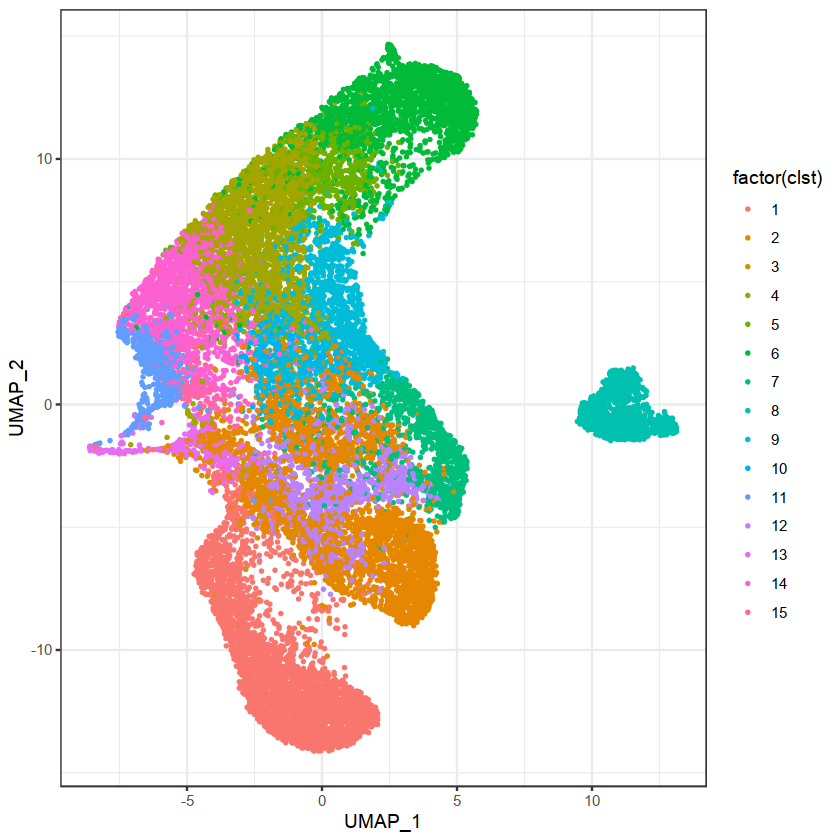

In [19]:
tmp = data.frame(scrna@reductions$umap@cell.embeddings)
tmp$clst = atac.to.rna.metadata$atac_cluster

tmp = tmp[sample(nrow(tmp), 20000), ]

ggplot(tmp) +
geom_point(aes(x=UMAP_1,y=UMAP_2, col=factor(clst)), size=0.5) +
theme_bw()

In [27]:
head(snrna_bc_order)

[1] "CAAACCGTCCAATAGC-1" "TACTTCGTCCAATAGC-1" "TTTGTGTTCCAATAGC-1"
[4] "CTCTCACAGATAAAGC-1" "GGCCTTAAGATAAAGC-1" "CCAAGTTAGATAAAGC-1"

In [29]:
head(snrna@reductions$umap@cell.embeddings[snrna_bc_order,])

,UMAP_1,UMAP_2
CAAACCGTCCAATAGC-1,-5.384802,-1.3984394
TACTTCGTCCAATAGC-1,-6.949060,1.8678476
TTTGTGTTCCAATAGC-1,3.301372,-0.3175140
CTCTCACAGATAAAGC-1,-6.160516,1.8122849
GGCCTTAAGATAAAGC-1,3.294820,0.1457154
CCAAGTTAGATAAAGC-1,-5.234700,-0.4343519


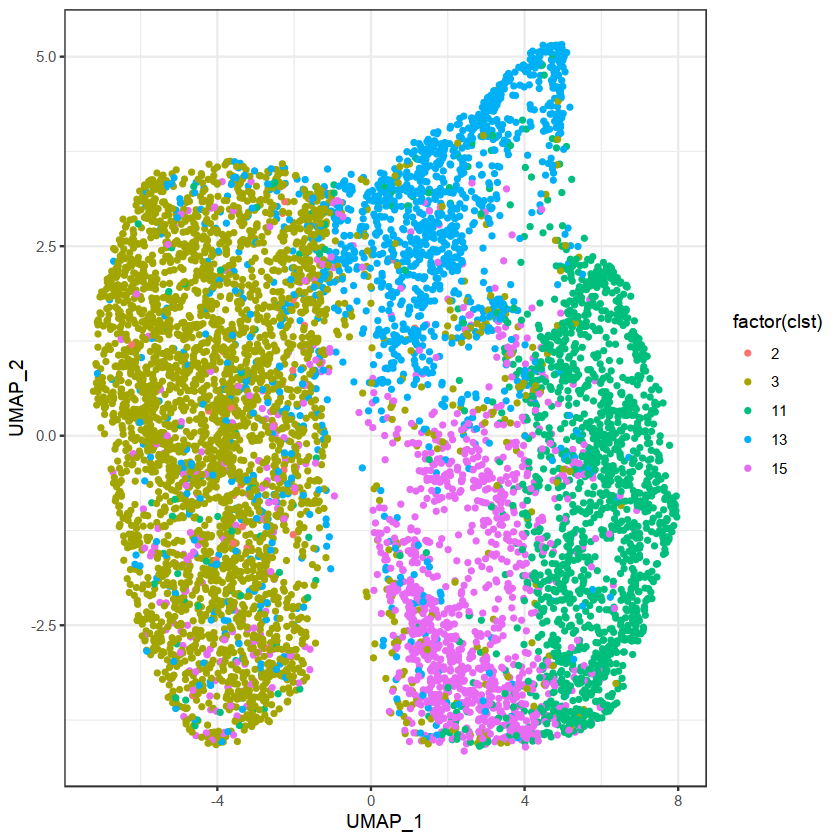

In [9]:
tmp = data.frame(snrna@reductions$umap@cell.embeddings[snrna_bc_order,])
tmp$clst = atac_metaData_multiome_filt$transfered_cluster

tmp = tmp[sample(nrow(tmp)), ]

ggplot(tmp) +
geom_point(aes(x=UMAP_1,y=UMAP_2, col=factor(clst)), size=1) +
theme_bw()

In [15]:
rna_to_atac_bc_map = atac_to_rna_bc_map
rownames(rna_to_atac_bc_map) = atac_to_rna_bc_map$RNA

In [36]:
snrna$trans_clst = atac_metaData_multiome_filt[paste(snrna$sample, paste("AAAAAAAA",rna_to_atac_bc_map[unlist(lapply(strsplit(colnames(snrna), "-"), "[[", 1)), "ATAC"], sep=''),
      sep='_'), "transfered_cluster"]
snrna = SetIdent(snrna, value="trans_clst")

In [39]:
table(snrna$trans_clst)


   2    3   11   13   15 
  28 3142 1563 1429 1216 

In [41]:
high_osk_vs_fibr = FindMarkers(snrna, only.pos = F, ident.1 = 11, ident.2 = 3, min.pct = 0.2)
high_osk_vs_fibr = high_osk_vs_fibr[high_osk_vs_fibr$p_val_adj < 0.01, ]

In [60]:
low_osk_vs_fibr = FindMarkers(snrna, only.pos = F, ident.1 = 15, ident.2 = 3, min.pct = 0.2)
low_osk_vs_fibr = low_osk_vs_fibr[low_osk_vs_fibr$p_val_adj < 0.01, ]

In [66]:
low_osk_vs_high_osk = FindMarkers(snrna, only.pos = F, ident.1 = 11, ident.2 = 15, min.pct = 0.2)
low_osk_vs_high_osk = low_osk_vs_high_osk[low_osk_vs_high_osk$p_val_adj < 0.01, ]

In [83]:
ker_vs_fibr = FindMarkers(snrna, only.pos = F, ident.1 = 13, ident.2 = 3, min.pct = 0.2)
ker_vs_fibr = ker_vs_fibr[ker_vs_fibr$p_val_adj < 0.01, ]

In [89]:
head(ker_vs_fibr, 20)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NFATC2,1.497551e-226,1.2184194,0.477,0.075,4.710098e-222
CPAMD8,4.423722e-197,0.9069840,0.297,0.011,1.391349e-192
GREM1,4.115713e-181,-0.9741828,0.428,0.824,1.294474e-176
FERMT1,5.462837e-181,0.9716059,0.422,0.074,1.718172e-176
KLF3,4.822682e-178,1.1117436,0.606,0.218,1.516830e-173
AC099520.1,1.107393e-176,1.5017286,0.308,0.024,3.482973e-172
CD55,2.073746e-167,0.9959828,0.577,0.197,6.522345e-163
STK32B,2.393134e-155,1.0091285,0.515,0.158,7.526886e-151
HMGA2,9.667055e-144,-0.8926196,0.768,0.914,3.040482e-139


In [43]:
dim(high_osk_vs_fibr)

[1] 977   5

In [61]:
dim(low_osk_vs_fibr)

[1] 589   5

In [64]:
dim(low_osk_vs_high_osk)

[1] 377   5

In [82]:
head(low_osk_vs_high_osk[(order(low_osk_vs_high_osk$avg_logFC)), ], 20)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LYPLAL1-DT,5.598510e-96,-1.5938540,0.114,0.439,1.760843e-91
MGAT4C,5.393219e-49,-1.1941629,0.106,0.317,1.696275e-44
ROBO2,1.599161e-21,-1.0311624,0.180,0.309,5.029681e-17
SLC7A11,5.288851e-114,-0.9279005,0.697,0.895,1.663450e-109
TXNRD1,2.663860e-88,-0.8980665,0.639,0.841,8.378373e-84
HAS2,5.268330e-48,-0.8143971,0.363,0.579,1.656995e-43
PCDH15,7.448351e-30,-0.7995871,0.110,0.262,2.342655e-25
LINC02582,2.782905e-49,-0.7864276,0.086,0.288,8.752794e-45
F3,5.904205e-62,-0.7743800,0.378,0.612,1.856991e-57


In [57]:
high_osk_vs_fibr["VIM", ]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VIM,8.931616e-143,-0.520863,0.914,0.978,2.809172e-138


In [47]:
head(high_osk_vs_fibr[order(high_osk_vs_fibr$avg_logFC), ], 20)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GREM1,1.030049e-268,-1.2849296,0.379,0.824,3.239711e-264
COL1A1,2.897167e-226,-1.1394198,0.460,0.840,9.112170e-222
FMN1,1.244226e-102,-1.0678002,0.269,0.571,3.913339e-98
FGF5,1.625481e-174,-1.0564461,0.328,0.691,5.112463e-170
COL1A2,1.843360e-211,-1.0418081,0.555,0.852,5.797735e-207
CHRM2,4.494363e-77,-1.0396271,0.267,0.500,1.413567e-72
SMURF2,4.108193e-213,-1.0309455,0.670,0.903,1.292109e-208
UACA,2.831843e-225,-1.0269052,0.573,0.875,8.906712e-221
VEGFC,1.573089e-182,-1.0183912,0.571,0.843,4.947681e-178


In [62]:
head(low_osk_vs_fibr[order(low_osk_vs_fibr$avg_logFC), ], 10)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FMN1,1.360225e-78,-0.9523066,0.269,0.571,4.278178e-74
GREM1,7.431269e-159,-0.9510550,0.436,0.824,2.337283e-154
SMURF2,2.001304e-159,-0.9489310,0.687,0.903,6.294501e-155
FRMD6,1.684407e-132,-0.9480878,0.317,0.696,5.297795e-128
INHBA,8.606837e-121,-0.9326745,0.206,0.589,2.707023e-116
COL1A1,2.566181e-148,-0.9301315,0.486,0.840,8.071152e-144
DCC,7.042041e-57,-0.9200370,0.126,0.359,2.214863e-52
HMGA2,3.620113e-130,-0.9079043,0.784,0.914,1.138598e-125
ADAMTS6,3.183119e-71,-0.8926359,0.328,0.593,1.001155e-66


In [58]:
head(high_osk_vs_fibr[rev(order(high_osk_vs_fibr$avg_logFC)), ], 10)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAP2,0.000000e+00,2.342904,0.827,0.072,0.000000e+00
HS3ST5,0.000000e+00,1.995370,0.723,0.064,0.000000e+00
HDAC2-AS2,0.000000e+00,1.550405,0.671,0.086,0.000000e+00
AC099520.1,1.442222e-261,1.495018,0.407,0.024,4.536077e-257
JAKMIP2,6.906396e-229,1.301785,0.434,0.056,2.172200e-224
CACNA2D3,1.502299e-187,1.194797,0.293,0.014,4.725031e-183
GRIP1,4.962485e-205,1.156460,0.440,0.069,1.560801e-200
COL11A1,1.099343e-166,1.142536,0.491,0.133,3.457653e-162
EDIL3,1.605440e-270,1.128900,0.770,0.274,5.049431e-266


### Get Day x Cluster TPM

### scRNA

In [187]:
scrna_sub = subset(scrna, subset = sample %in% c("D0", "D2"))
scrna_sub = subset(scrna_sub, subset = trans_clst %in% c(1,2,3,13,15,11))

scday_clst = factor(paste(scrna_sub$sample, 
             scrna_sub$trans_clst, sep='-'), 
       levels = c(paste("D0", c(1,2,3,13,15,11), sep='-'), paste("D2", c(1,2,3,13,15,11), sep='-')))
scrna_cts = as.matrix(scrna_sub@assays$RNA@counts %*% sparseMatrix(i=seq(ncol(scrna_sub)), j=as.integer(scday_clst)))
colnames(scrna_cts) = levels(scday_clst)
scrna_cts = scrna_cts[, names(table(scday_clst))[table(scday_clst)>100]]
scrna_tpm = 1e6*t(t(scrna_cts)/colSums(scrna_cts))

In [188]:
head(scrna_tpm)

,D0-1,D2-1,D2-2,D2-13,D2-15,D2-11
OR4F5,0.0000000,0.02555051,0.0000000,0.0000000,0.0000000,0.04998105
AL627309.1,0.1164943,0.05110102,0.0000000,0.1574659,0.1633513,0.19992420
AL627309.5,0.4576561,0.30660614,0.8134006,0.2361988,0.2450270,0.39984840
AL627309.4,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000
AP006222.2,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000
AL669831.2,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000


In [189]:
cor(scrna_tpm, method='spearman')

,D0-1,D2-1,D2-2,D2-13,D2-15,D2-11
D0-1,1.0000000,0.9622472,0.9231006,0.9060994,0.9220369,0.9206620
D2-1,0.9622472,1.0000000,0.9349228,0.9293145,0.9452899,0.9439446
D2-2,0.9231006,0.9349228,1.0000000,0.9143993,0.9270889,0.9154450
D2-13,0.9060994,0.9293145,0.9143993,1.0000000,0.9269487,0.9329930
D2-15,0.9220369,0.9452899,0.9270889,0.9269487,1.0000000,0.9499617
D2-11,0.9206620,0.9439446,0.9154450,0.9329930,0.9499617,1.0000000


### snRNA

In [183]:
day_clst = factor(paste(atac_metaData_multiome_filt$sample, 
             atac_metaData_multiome_filt$transfered_cluster, sep='-'), 
       levels = c(paste("D1M", c(2,3,13,15,11), sep='-'), paste("D2M", c(2,3,13,15,11), sep='-')))
snrna_cts = as.matrix(snrna@assays$RNA@counts[, snrna_bc_order] %*% sparseMatrix(i=seq(ncol(snrna)), j=as.integer(day_clst)))
colnames(snrna_cts) = levels(day_clst)
snrna_cts = snrna_cts[, names(table(day_clst))[table(day_clst)>100]]
snrna_tpm = 1e6*t(t(snrna_cts)/colSums(snrna_cts))

In [184]:
head(snrna_tpm)

,D1M-3,D1M-13,D1M-15,D1M-11,D2M-3,D2M-13,D2M-15,D2M-11
MIR1302-2HG,0.0000000,0.000000,0.0000000,0.186249,0.0000000,0.2736853,0.0000000,0.0000000
OR4F5,0.0000000,0.000000,0.0000000,0.000000,0.1607156,0.0000000,0.0000000,0.0000000
AL627309.1,0.5306328,1.174274,0.9002841,1.303743,0.6428625,1.3684267,0.3410753,0.7423607
AL627309.3,0.0000000,0.000000,0.0000000,0.000000,0.1607156,0.0000000,0.0000000,0.0000000
AL627309.5,0.7075104,0.782849,1.3504261,0.744996,1.6071563,2.7368535,3.4107529,1.2372679
AL627309.4,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.2474536


In [185]:
snrna_tpm["JAKMIP2", ]

D1M-3    D1M-13    D1M-15    D1M-11     D2M-3    D2M-13    D2M-15    D2M-11 
 16.44962  14.09128  74.27344  85.67455  30.37525  55.55813 230.22582 509.01201

In [186]:
cor(snrna_tpm, method='spearman')

,D1M-3,D1M-13,D1M-15,D1M-11,D2M-3,D2M-13,D2M-15,D2M-11
D1M-3,1.0000000,0.9339309,0.9325851,0.9428236,0.9522511,0.9304261,0.9292760,0.9315318
D1M-13,0.9339309,1.0000000,0.9231085,0.9329441,0.9331249,0.9313691,0.9193057,0.9245894
D1M-15,0.9325851,0.9231085,1.0000000,0.9334429,0.9298928,0.9201222,0.9236967,0.9247036
D1M-11,0.9428236,0.9329441,0.9334429,1.0000000,0.9398912,0.9342677,0.9283724,0.9458284
D2M-3,0.9522511,0.9331249,0.9298928,0.9398912,1.0000000,0.9392862,0.9364239,0.9385299
D2M-13,0.9304261,0.9313691,0.9201222,0.9342677,0.9392862,1.0000000,0.9292017,0.9385023
D2M-15,0.9292760,0.9193057,0.9236967,0.9283724,0.9364239,0.9292017,1.0000000,0.9348164
D2M-11,0.9315318,0.9245894,0.9247036,0.9458284,0.9385299,0.9385023,0.9348164,1.0000000


In [191]:
common_genes = intersect(rownames(snrna_tpm), rownames(scrna_tpm))
common_cts = cbind(scrna_cts[common_genes, ], snrna_cts[common_genes, ])
common_tpm = cbind(scrna_tpm[common_genes, ], snrna_tpm[common_genes, ])
head(common_tpm)

,D0-1,D2-1,D2-2,D2-13,D2-15,D2-11,D1M-3,D1M-13,D1M-15,D1M-11,D2M-3,D2M-13,D2M-15,D2M-11
OR4F5,0.0000000,0.02555051,0.0000000,0.0000000,0.0000000,0.04998105,0.0000000,0.000000,0.0000000,0.000000,0.1607156,0.0000000,0.0000000,0.0000000
AL627309.1,0.1164943,0.05110102,0.0000000,0.1574659,0.1633513,0.19992420,0.5306328,1.174274,0.9002841,1.303743,0.6428625,1.3684267,0.3410753,0.7423607
AL627309.5,0.4576561,0.30660614,0.8134006,0.2361988,0.2450270,0.39984840,0.7075104,0.782849,1.3504261,0.744996,1.6071563,2.7368535,3.4107529,1.2372679
AL627309.4,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.2474536
AP006222.2,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000,0.3410753,0.0000000
AL669831.2,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.000000,0.0000000,0.000000,0.3214313,0.5473707,0.3410753,0.0000000


In [192]:
head(common_cts)

,D0-1,D2-1,D2-2,D2-13,D2-15,D2-11,D1M-3,D1M-13,D1M-15,D1M-11,D2M-3,D2M-13,D2M-15,D2M-11
OR4F5,0,1,0,0,0,1,0,0,0,0,1,0,0,0
AL627309.1,14,2,0,2,2,4,3,3,2,7,4,5,1,3
AL627309.5,55,12,2,3,3,8,4,2,3,4,10,10,10,5
AL627309.4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AP006222.2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
AL669831.2,0,0,0,0,0,0,0,0,0,0,2,2,1,0


In [152]:
cor(common_tpm, method='spearman')

,D0-1,D2-1,D2-2,D2-13,D2-15,D2-11,D1M-3,D1M-13,D1M-15,D1M-11,D2M-3,D2M-13,D2M-15,D2M-11
D0-1,1.0000000,0.9664247,0.9299426,0.9099987,0.9267058,0.9238798,0.7703194,0.7541694,0.7451445,0.7290717,0.7870944,0.7674261,0.7564448,0.7449614
D2-1,0.9664247,1.0000000,0.9413892,0.9335098,0.9502392,0.9476443,0.7659511,0.7561465,0.7458825,0.7313203,0.7854569,0.7737859,0.7609698,0.7513991
D2-2,0.9299426,0.9413892,1.0000000,0.9184592,0.9312466,0.9200842,0.7571853,0.7522671,0.7425108,0.7254671,0.7767898,0.7708302,0.7572110,0.7468267
D2-13,0.9099987,0.9335098,0.9184592,1.0000000,0.9308594,0.9369092,0.7195813,0.7331316,0.7120053,0.7004242,0.7403052,0.7640483,0.7245622,0.7248209
D2-15,0.9267058,0.9502392,0.9312466,0.9308594,1.0000000,0.9550837,0.7545904,0.7544845,0.7481186,0.7322450,0.7760088,0.7754760,0.7705670,0.7592787
D2-11,0.9238798,0.9476443,0.9200842,0.9369092,0.9550837,1.0000000,0.7499679,0.7516458,0.7448378,0.7360615,0.7699171,0.7754615,0.7653214,0.7637454
D1M-3,0.7703194,0.7659511,0.7571853,0.7195813,0.7545904,0.7499679,1.0000000,0.9471587,0.9469297,0.9538921,0.9644360,0.9418902,0.9422420,0.9430897
D1M-13,0.7541694,0.7561465,0.7522671,0.7331316,0.7544845,0.7516458,0.9471587,1.0000000,0.9383398,0.9460426,0.9452923,0.9445547,0.9325516,0.9376823
D1M-15,0.7451445,0.7458825,0.7425108,0.7120053,0.7481186,0.7448378,0.9469297,0.9383398,1.0000000,0.9480050,0.9440024,0.9340822,0.9385058,0.9396369
D1M-11,0.7290717,0.7313203,0.7254671,0.7004242,0.7322450,0.7360615,0.9538921,0.9460426,0.9480050,1.0000000,0.9507481,0.9461268,0.9418303,0.9580829


In [195]:
common_cts = common_cts[rowSums(common_cts)>10, ]
common_log_norm = log2(1+t(t(common_cts)/estimateSizeFactorsForMatrix(common_cts)))

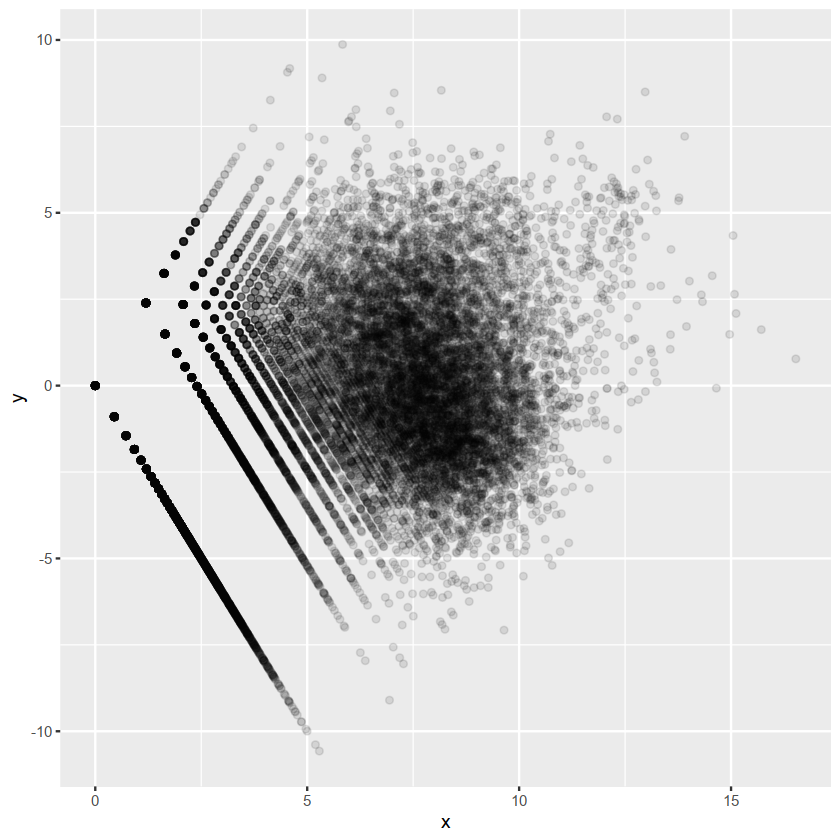

In [199]:
ggplot(data.frame(x=(common_log_norm[, "D2-2"] + common_log_norm[, "D2M-3"])/2,
                  y=common_log_norm[, "D2-2"] - common_log_norm[, "D2M-3"])) +
 geom_point(aes(x=x,y=y), alpha=0.1)

In [228]:
cond = ((common_log_norm[, "D2-2"] + common_log_norm[, "D2M-3"])/2)>4 &
            (common_log_norm[, "D2-2"] - common_log_norm[, "D2M-3"]) > 2
length(rownames(common_log_norm)[cond])
# write.table(rownames(common_log_norm)[cond], "snUp.txt", row.names=F, quote=F, col.names=F)

[1] 2873

scUP are enriched for cytoplasmic terms...makes sense. Genes like FOS are much higher in sc than sn.

See Fig 2 of https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209648.

In [230]:
common_log_norm["FOS", ]

D0-1       D2-1       D2-2      D2-13      D2-15      D2-11      D1M-3 
12.5814596 11.0653968 10.7696950  9.4237534  9.4032104  8.3465705  1.5845462 
    D1M-13     D1M-15     D1M-11      D2M-3     D2M-13     D2M-15     D2M-11 
 1.6412190  1.8294980  2.5768226  0.8993767  2.3621397  1.5431233  3.1541705

In [229]:
common_log_norm["CNTNAP2", ]

D0-1      D2-1      D2-2     D2-13     D2-15     D2-11     D1M-3    D1M-13 
0.0000000 0.3380532 0.0000000 0.0000000 0.0000000 0.0000000 5.8322764 5.5736304 
   D1M-15    D1M-11     D2M-3    D2M-13    D2M-15    D2M-11 
6.1802225 6.6907606 5.3505665 5.4974244 5.6659166 6.1723330

In [208]:
rownames(common_log_norm)[cond]

[1] "ADRA2C" "CXCL10" "POU5F1" "IFNB1"  "PTGDS"  "HBB"    "CST6"   "FOS"

In [140]:
lol = as.character(as.vector(read.table("./fibr_ipsc_diff.txt")$V1))

In [141]:
scrna_tpm["FN1", ]

D0-1       D2-1       D2-2      D2-13      D2-15      D2-11 
1001.67598  642.64648  726.77345  209.42961  102.50296   94.86403

In [95]:
snrna_tpm["FN1", ]

D1M-2     D1M-3    D1M-13    D1M-15    D1M-11     D2M-2     D2M-3    D2M-13 
1578.5676 1081.9603  744.8809  642.3527  617.7880 1117.8213 1062.4911  523.0127 
   D2M-15    D2M-11 
 282.7514  401.1223

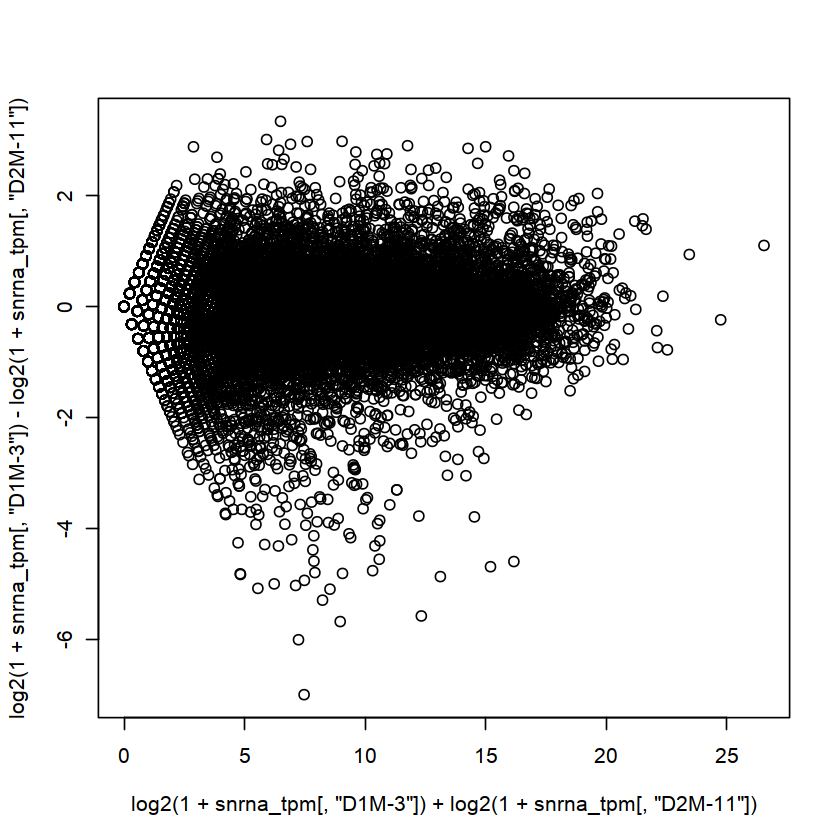

In [87]:
plot(log2(1+snrna_tpm[,"D1M-3"]) + log2(1+snrna_tpm[,"D2M-11"]),
    log2(1+snrna_tpm[,"D1M-3"]) - log2(1+snrna_tpm[,"D2M-11"]))

### Mystery cells analysis

Check if they are possibly doublets.

In [43]:
cond = (atac_metaData_multiome_filt$umap1 < -2)& (atac_metaData_multiome_filt$umap2 > 5) & 
                                                             (atac_metaData_multiome_filt$umap2 < 7.2)
mystery_bc = atac_to_rna_bc_map[atac_metaData_multiome_filt$barcode[cond],"RNA"]
mystery_bc = paste(mystery_bc, ifelse(atac_metaData_multiome_filt$sample[cond]=="D1M", 1,2), sep='-')
head(mystery_bc)

[1] "CCCGTAAAGATAAAGC-1" "ATTACCGCACCTCGCT-1" "CTGCTACTCTAACTGA-1"
[4] "TGCACACCAGAGAGCC-1" "TTGCACACAAGGTCGA-1" "ATATAGGCAAACGCGA-1"

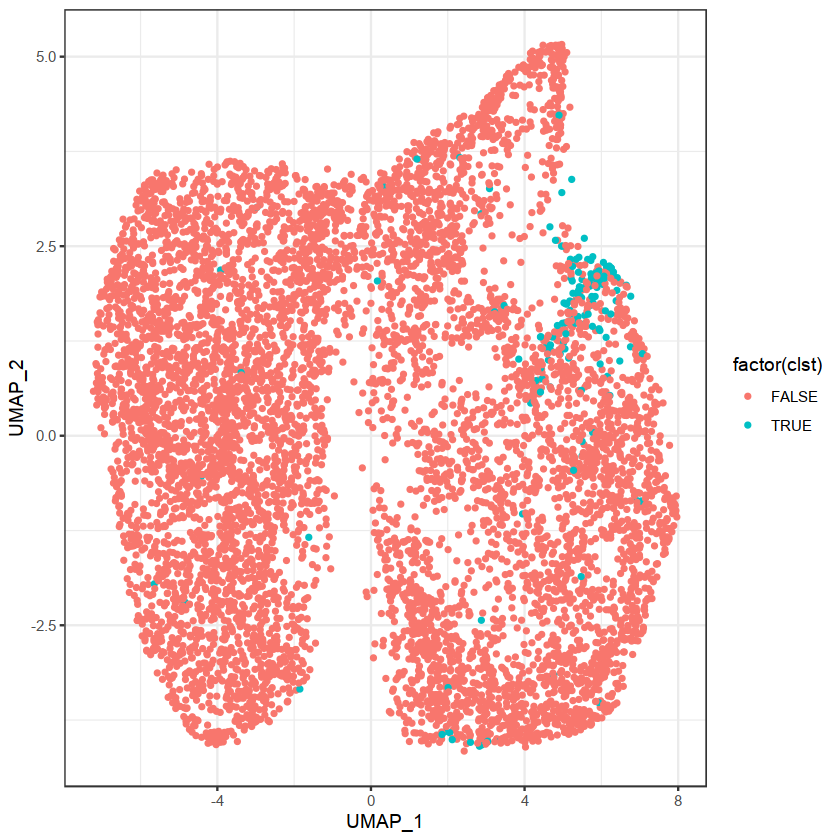

In [37]:
tmp = data.frame(snrna@reductions$umap@cell.embeddings[snrna_bc_order,])
tmp$clst = cond

tmp = tmp[sample(nrow(tmp)), ]

ggplot(tmp) +
geom_point(aes(x=UMAP_1,y=UMAP_2, col=factor(clst)), size=1) +
theme_bw()

In [36]:
length(mystery_bc)

[1] 159

In [58]:
library(DoubletFinder)
doublets = c()
doublet_score = c()

# TODO: technically pK needs to be optimised per sample [need to code that in]
for (d in c("D1M", "D2M")) {
    rna_sample = subset(snrna, subset = sample==d)
    
    rna_sample <- NormalizeData(rna_sample)
    rna_sample <- FindVariableFeatures(rna_sample, selection.method = "vst", nfeatures = 2000)
    all.genes <- rownames(rna_sample)
    rna_sample <- ScaleData(rna_sample, features = all.genes)
    rna_sample <- RunPCA(rna_sample, features = VariableFeatures(object = rna_sample))
    rna_sample <- RunUMAP(rna_sample, dims = 1:10)
    
    nExp_poi <- round(0.15*ncol(rna_sample)) # 15% stringent (?)
    rna_sample <- doubletFinder_v3(rna_sample, PCs = 1:10, pN = 0.25, pK = 0.01, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
    
    doublets = c(doublets, rownames(rna_sample@meta.data)[rna_sample@meta.data[, grep("DF.classifications", colnames(rna_sample@meta.data))[1]]=="Doublet"])
    doublet_score = c(doublet_score, rna_sample@meta.data[, grep("pANN_", colnames(rna_sample@meta.data))[1]])
}

names(doublet_score) = colnames(snrna)

Centering and scaling data matrix

PC_ 1 
Positive:  MAP2, HS3ST5, EDIL3, HDAC2-AS2, THRB, CASC15, POU5F1, KLF4, TMTC2, GRIP1 
	   CACNA2D3, CACNA2D1, PDE1A, SOX2, POU2F1, AC073050.1, CHSY3, PRKAR2B, FNDC3A, SOX5 
	   DGKH, DOK6, SYT1, KMT2C, AC099520.1, EFNA5, COL11A1, VAV2, MARCH3, OXR1 
Negative:  UACA, VEGFC, FRMD6, HMGA2, THBS1, FMN2, HMGA2-AS1, FST, MYBL1, FMN1 
	   CHRM2, ADAMTS6, ITGA2, CFAP299, RFX8, AC009264.1, MIR31HG, PDE5A, PDGFRA, NEAT1 
	   DCC, FAP, SERPINB2, NTM, SLC8A1, NCKAP5, SEMA3C, APOLD1, GREM2, SGIP1 
PC_ 2 
Positive:  CHRM2, AC009264.1, UACA, HMGA2, VEGFC, PDE5A, FMN2, FMN1, FAM155A, IL1RAPL1 
	   HMGA2-AS1, SLC4A4, MYBL1, AC092691.1, THSD4, FRMD6, SGIP1, AFF3, PDE4B, DCC 
	   THBS1, FAP, FST, IFI44L, PARP14, SLC8A1, PRR16, GPC6, PRKG1, GREM2 
Negative:  KLF3, NFATC2, CD55, FERMT1, LRRFIP1, CPAMD8, TIMP3, STK32B, SLC6A6, H19 
	   VAV2, OSBP2, BMPER, TYK2, LINC00707, CAPRIN2, DSP, DNPEP, RCOR1, EPPK1 
	   CPLX1, TDRP, TIAM1, MEDAG, ICAM1, CDYL2, CCDC112, HS3ST5,

[1] "Creating 1072 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  HS3ST5, HDAC2-AS2, MAP2, AC099520.1, JAKMIP2, EDIL3, DOK6, AC092957.1, ATP9B, GRIP1 
	   KCNQ5, THSD7A, PPM1E, ASXL3, FGD4, COL11A1, NKAIN2, PARD3B, CYP1B1, COBLL1 
	   CACNA2D1, EFNA5, MCU, MET, THRB, KLF3, SEMA3E, LUZP2, LINC00366, CD55 
Negative:  GREM1, COL1A1, COL1A2, SMURF2, UACA, FN1, INHBA, MYO10, FRMD6, FGF5 
	   TRHDE, ITGA2, EXT1, BNC2, THBS1, LGALS1, FMN1, VEGFC, NTM, PRR16 
	   RND3, FMN2, HMGA2, ADAMTS6, CHRM2, MT2A, CRIM1, CDH13, RFX8, AFF3 
PC_ 2 
Positive:  CPAMD8, ZBTB46, COL9A3, TNNT1, NPTX1, PLCG2, CACNA2D3, ATP2B4, COL6A1, OBSCN 
	   OCA2, SLC6A8, SLC6A6, MKNK2, PTPRN2, TM4SF19, HBA1, TDRP, FSTL3, NEBL 
	   DSP, SNED1, CKB, IGFBP6, HBA2, AL353593.1, MARVELD3, CRYM, MLF1, TNFAIP2 
Negative:  GPC6, PARD3B, PDE4B, SLC7A11, ARHGAP18, DOK6, ROBO1, PLCB1, LYPLAL1-DT, SUPT3H 
	   MAP4K3, PCDH7, CDH6, COL3A1, PCDH15, IL1RAPL1, JAKMIP2, MGAT4C, COL11A1, AC092957.1 
	   MEF2C, FAM155A, NBEA, SOX5, AGMO, AL356124.1, PCDH10,

[1] "Creating 1387 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


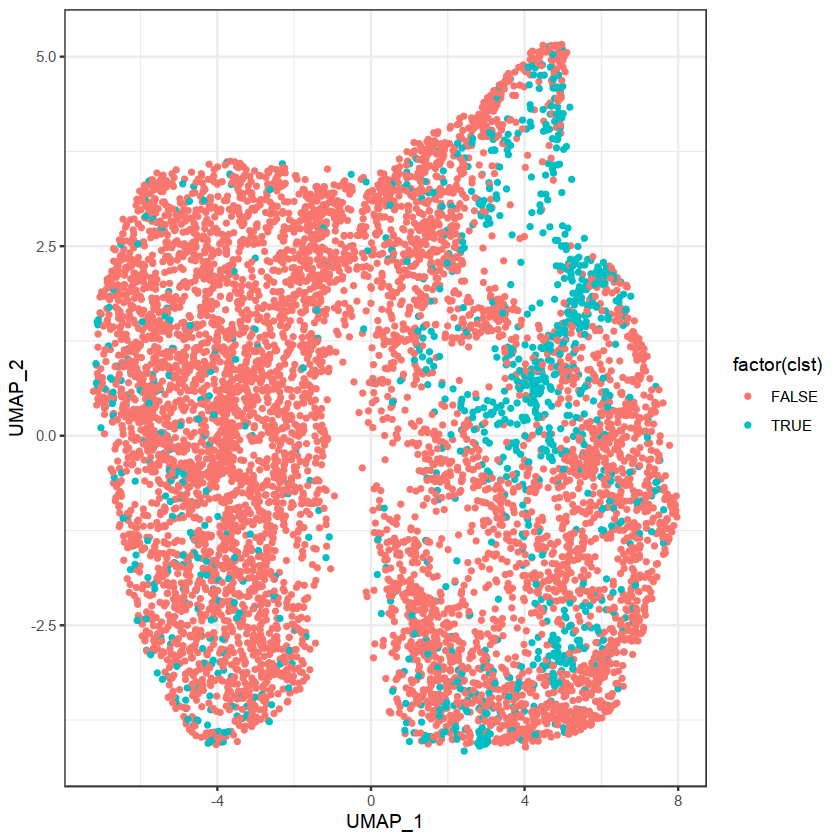

In [60]:
tmp = data.frame(snrna@reductions$umap@cell.embeddings)
tmp$clst = colnames(snrna) %in% doublets

tmp = tmp[sample(nrow(tmp)), ]

ggplot(tmp) +
geom_point(aes(x=UMAP_1,y=UMAP_2, col=factor(clst)), size=1) +
theme_bw()

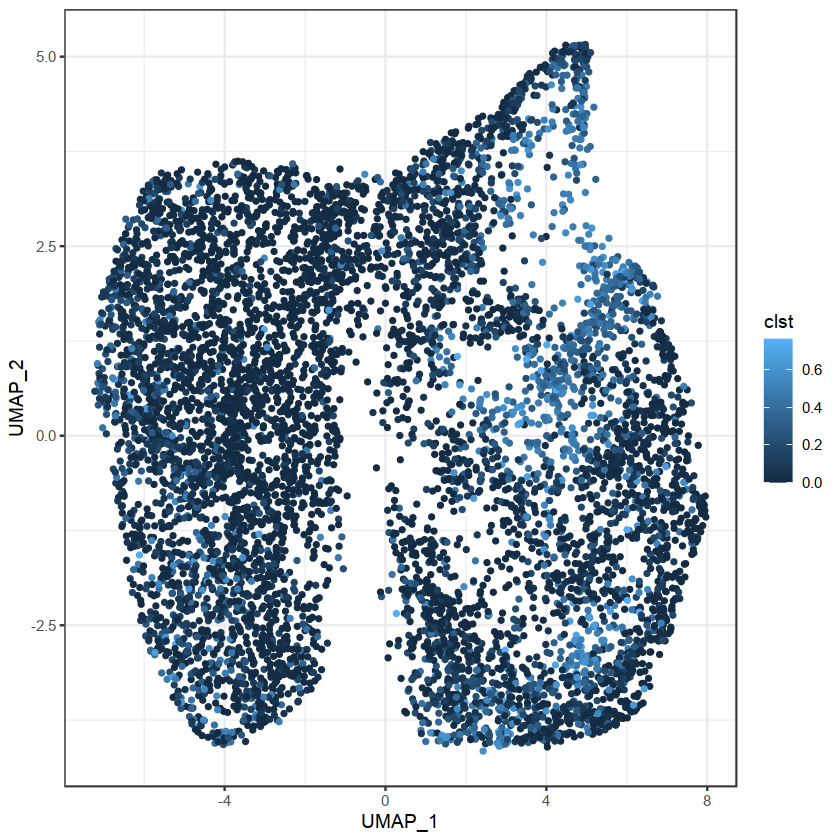

In [62]:
tmp = data.frame(snrna@reductions$umap@cell.embeddings)
tmp$clst = doublet_score

tmp = tmp[sample(nrow(tmp)), ]

ggplot(tmp) +
geom_point(aes(x=UMAP_1,y=UMAP_2, col=clst), size=1) +
theme_bw()